# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from keras.utils import to_categorical
import pickle
from evaluate_model import evaluate_model

2023-03-08 14:16:49.992064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import GridSearchCV

# Importing the Dataset for training and testing

In [3]:
df = pd.read_csv('data/Transactions.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,323,PAYMENT,5849.15,C864081747,0.0,0.00,M176058151,0.00,0.00,0,0
1,371,DEBIT,745.05,C120002503,32743.0,31997.95,C334067696,1238896.36,1239641.42,0,0
2,255,CASH_OUT,112914.60,C1366114345,104189.0,0.00,C1319037396,0.00,112914.60,0,0
3,354,TRANSFER,5273835.65,C2025766461,0.0,0.00,C1967040934,12217447.87,17491283.52,0,0
4,136,CASH_IN,443575.95,C1544741988,29790.0,473365.95,C269225067,749890.69,306314.74,0,0


In [5]:
df.shape

(6044489, 11)

# Data Exporatory Analysis and Visualization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044489 entries, 0 to 6044488
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 507.3+ MB


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.044489e+06,6.044489e+06,6.044489e+06,6.044489e+06,6.044489e+06,6.044489e+06,6.044489e+06,6.044489e+06
mean,2.434016e+02,1.799064e+05,8.340335e+05,8.552848e+05,1.101027e+06,1.225379e+06,1.292582e-03,2.481599e-06
std,1.423322e+02,6.051710e+05,2.888509e+06,2.924335e+06,3.403532e+06,3.679989e+06,3.592926e-02,1.575307e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.339242e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.484131e+04,1.421500e+04,0.000000e+00,1.326744e+05,2.146123e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.086925e+05,1.073329e+05,1.442895e+05,9.431092e+05,1.111941e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no null values in the dataset.

In [9]:
df.duplicated().sum()

0

There are no duplicate values.

In [10]:
# checking the number of different types of transactions
df['type'].value_counts()

CASH_OUT    2125441
PAYMENT     2043833
CASH_IN     1329526
TRANSFER     506321
DEBIT         39368
Name: type, dtype: int64

There are 5 types of payments.
Cash_out types of transactions is the highest

<Axes: xlabel='type', ylabel='count'>

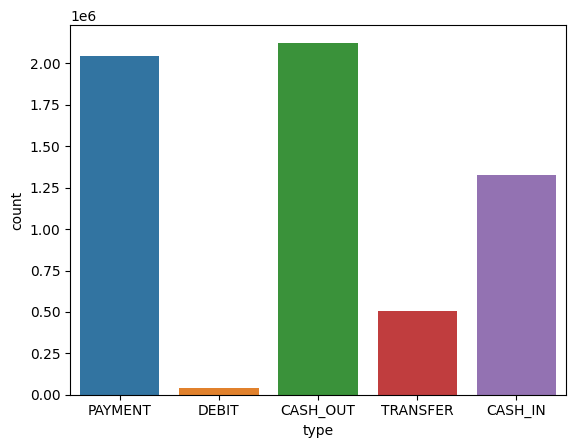

In [11]:
sns.countplot(x='type', data=df)

In [12]:
#Ckecking the maximun and minimum amount
print('Minimum amount: ',df.amount.min())
print('Maximum amount: ',df.amount.max())

Minimum amount:  0.0
Maximum amount:  92445516.64


<Axes: title={'center': 'amount'}, xlabel='isFraud'>

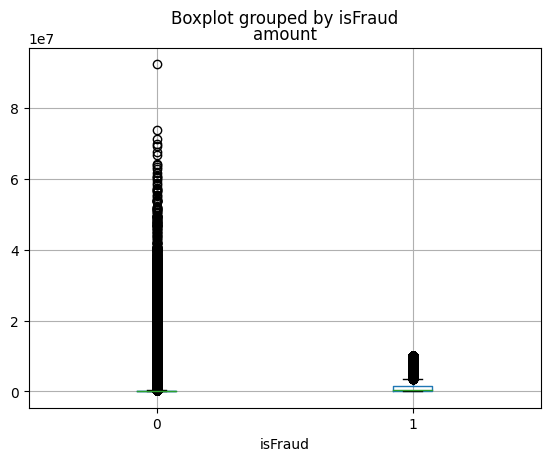

In [13]:
# Checking the realtion between amount and isFraud Column
df.boxplot(column='amount', by='isFraud')

Taking a closer look at isFlaggedFraud Column

In [14]:
df['isFlaggedFraud'].value_counts()

0    6044474
1         15
Name: isFlaggedFraud, dtype: int64

Out of 60 lakhs transactions only 15 transactions are actually flagged fraud. So this coulmns is not significant enough.

In [15]:
# Number of Frauds and non - fraud transactions
df['isFraud'].value_counts()

0    6036676
1       7813
Name: isFraud, dtype: int64

In [16]:
# Precent of fruad transactons
percent_fraud = round((df[df.isFraud == 1].isFraud.count()/df.shape[0]) * 100,3)
print('Percentage of fraud transactions :', percent_fraud)

Percentage of fraud transactions : 0.129


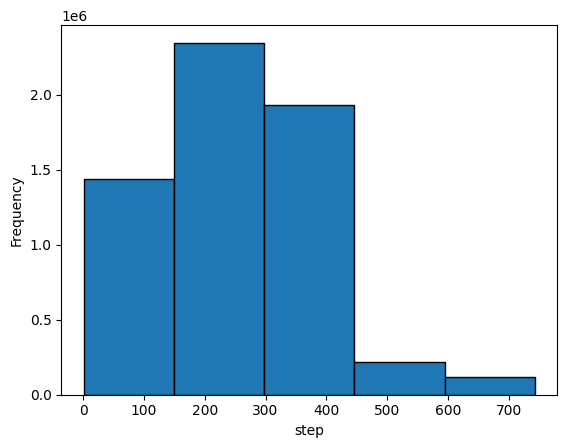

In [17]:
plt.xlabel('step')
df['step'].plot(kind='hist', bins=5, edgecolor = 'black')
plt.show()

/tmp/ipykernel_16207/395256865.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['step'], bins=50)


<Axes: xlabel='step', ylabel='Density'>

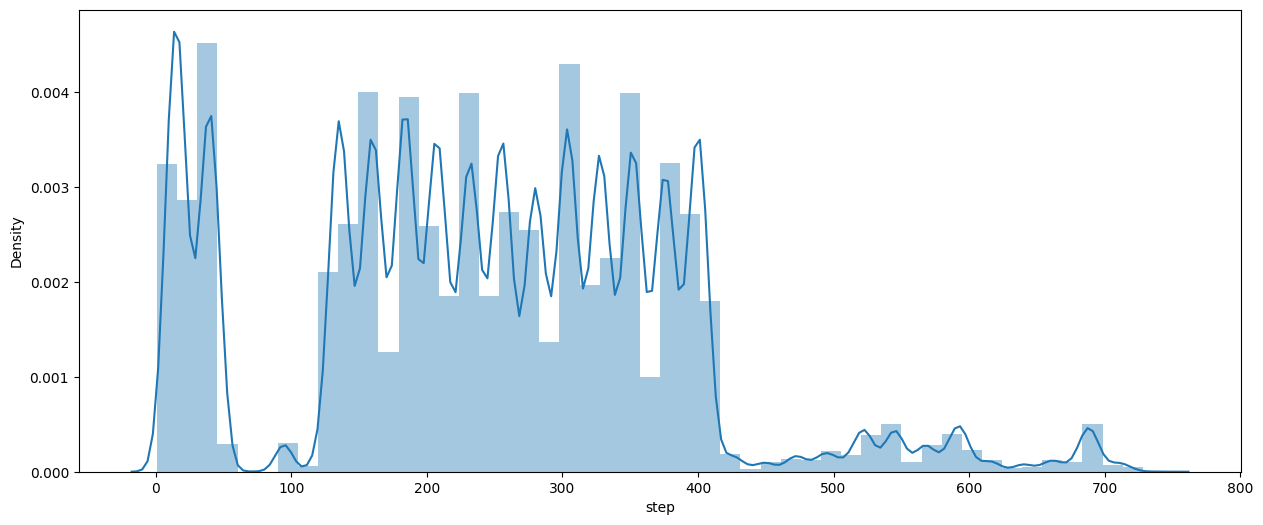

In [18]:
plt.figure(figsize=(15, 6))
sns.distplot(df['step'], bins=50)

Taking a closer look at nameDest column

In [19]:
fraudster = df.nameDest.value_counts()

<Axes: >

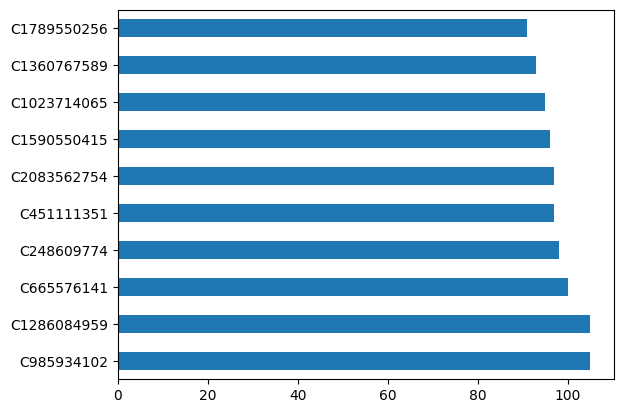

In [20]:
fraudster[:10].plot(kind='barh')

These are the ids' of top 10 fraudsters

In [21]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

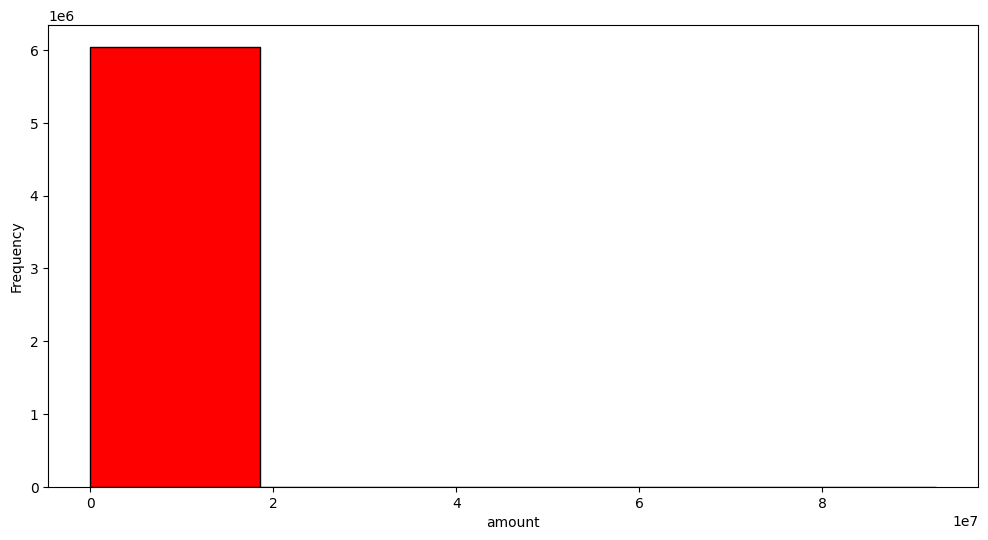

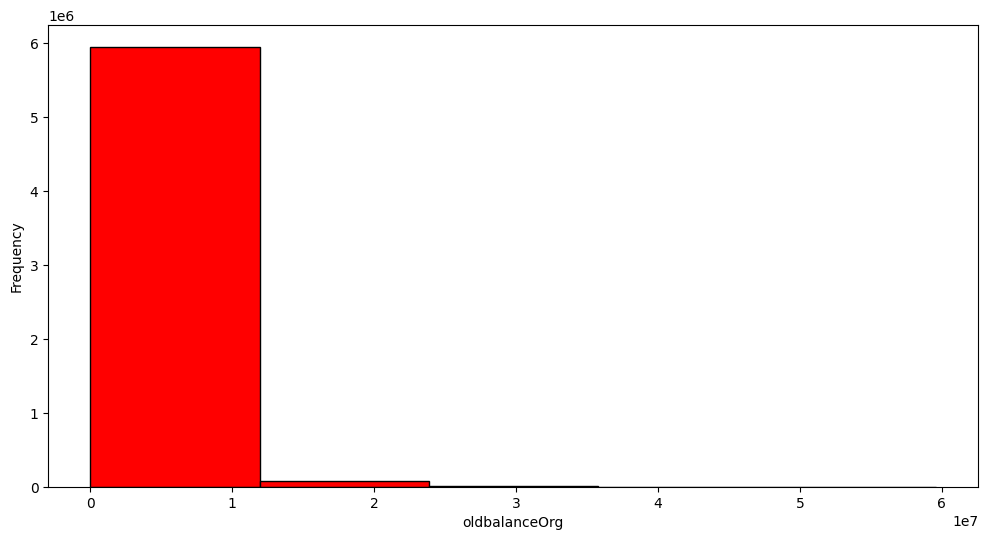

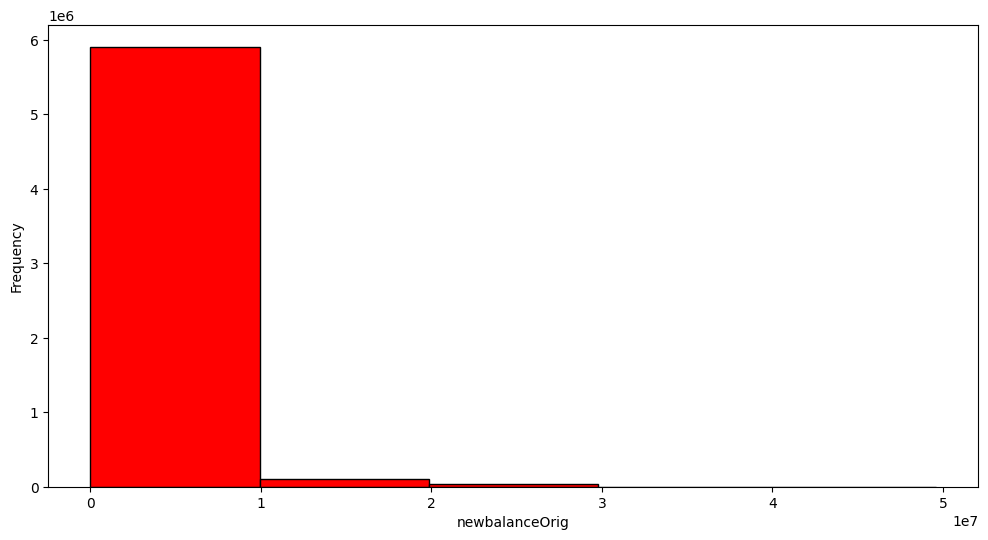

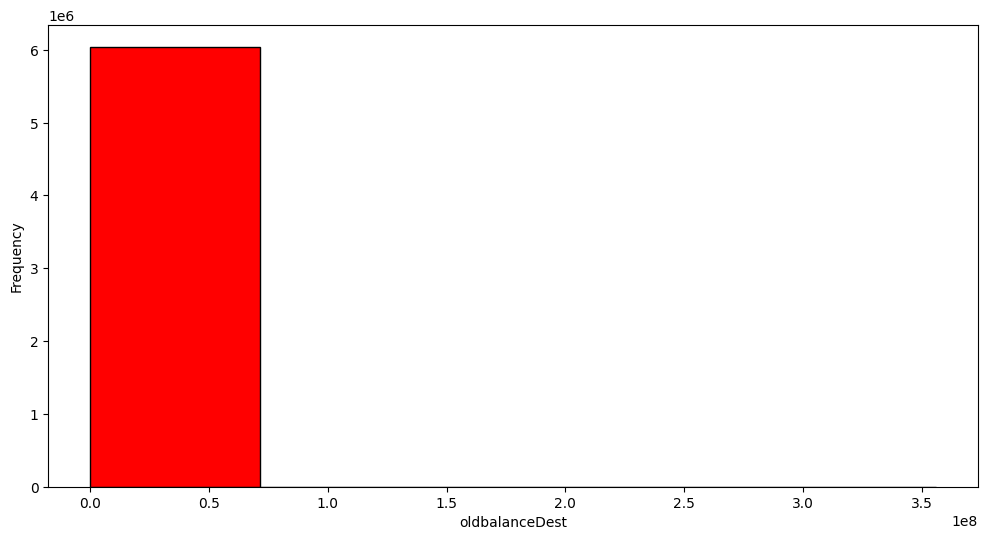

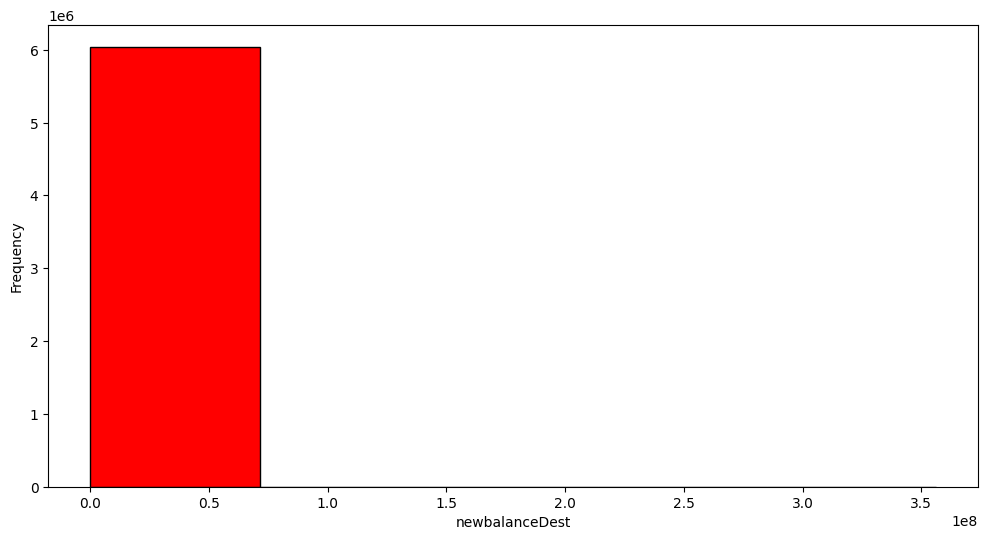

In [22]:
for i in feature:
    plt.xlabel(i)
    df[i].plot(kind='hist', bins=5, figsize=(12,6), facecolor='red',edgecolor='black')
    plt.show()

We can see there are outliers in the data

/tmp/ipykernel_16207/3716650988.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()# plot the heatmap


<Axes: >

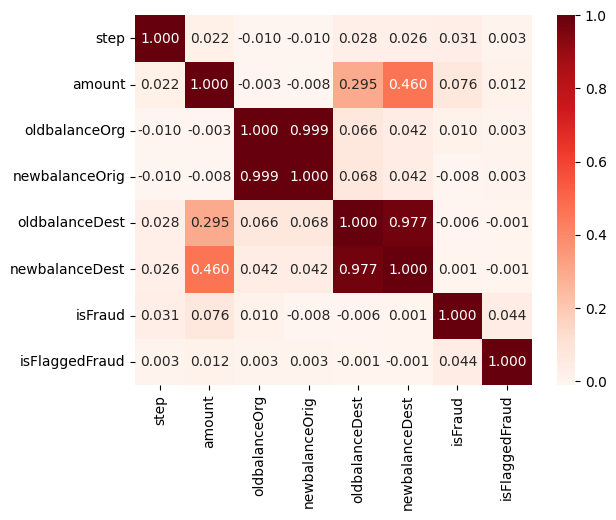

In [23]:
#bivariate Analysis
corr = df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='Reds' ,fmt=".3f")

There is high correlation between newbalanceOrg and oldbalanceOrg. And also between newbalanceDest and oldbalanceDest. Apart from this other co relations are relatively low.

# Data Preprocessing

In [24]:
df = df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud']]

In [25]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,PAYMENT,5849.15,0.0,0.00,0
1,DEBIT,745.05,32743.0,31997.95,0
2,CASH_OUT,112914.60,104189.0,0.00,0
3,TRANSFER,5273835.65,0.0,0.00,0
4,CASH_IN,443575.95,29790.0,473365.95,0


### Label Encoding

In [26]:
le = LabelEncoder()

In [27]:
df['type'] = le.fit_transform(df['type'])

In [28]:
df.dtypes

type                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
isFraud             int64
dtype: object

### Train and Test Split

In [82]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [83]:
ss = StratifiedShuffleSplit(n_splits = 1,
                            test_size = 0.2,
                            train_size = 0.8,
                            random_state = 12)    

In [84]:
for train_index, test_index in ss.split(X, y):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

# Handing Imbalance Classes of training dataset

In [85]:
print('Number of frauds:', train_df.isFraud[train_df['isFraud'] == 1].count())
print('Number of Non frauds:', train_df.isFraud[train_df['isFraud'] == 0].count())

Number of frauds: 6250
Number of Non frauds: 4829341


### Under Sampling

In [86]:
fraud_df = train_df.loc[train_df['isFraud'] == 1]
non_fraud_df = train_df.loc[train_df['isFraud'] == 0][:1500000]

In [87]:
train_df = pd.concat([fraud_df, non_fraud_df])

In [88]:
# After under sampling
print('Number of frauds:', train_df.isFraud[train_df['isFraud'] == 1].count())
print('Number of Non frauds:', train_df.isFraud[train_df['isFraud'] == 0].count())

Number of frauds: 6250
Number of Non frauds: 1500000


### Over Sampling

Generating approximately  fraud transactions

In [89]:
X = train_df.iloc[:,:-1]
y = train_df.iloc[:,-1]

In [90]:
smote = SMOTE(sampling_strategy=0.1)

In [91]:
X_train, y_train = smote.fit_resample(X, y)

In [92]:
print(len(y_train))

1650000


In [93]:
count_fraud = 0
count_non_fraud = 0
for i in y_train:
    if i == 1:
        count_fraud += 1
    if i == 0:
        count_non_fraud += 1
print('Number of fraud transactions:', count_fraud)
print('Number of Non Fraud transactions:', count_non_fraud)

Number of fraud transactions: 150000
Number of Non Fraud transactions: 1500000


In [94]:
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

# Models

## 1. Random Forest

In [43]:
rf = RandomForestClassifier(n_estimators = 200, criterion = 'log_loss')

In [44]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', n_estimators=200)

In [45]:
rf_eval = evaluate_model(rf, X_test, y_test)

Accuracy Score    0.9990942163855016
Precision score   0.5905572755417957
Recall score      0.9763275751759437
f1 score          0.735953701470943
True Negatives   1206277
False positives   1058
False negatives   37
True positives    1526


### Hyperparameter tuning

In [76]:
rf1 = RandomForestClassifier()

In [77]:
params_grid = {'n_estimators':[100,300,400], 'criterion' : ['entropy', 'log_loss', 'gini']}

In [78]:
grid_search = GridSearchCV(rf1, params_grid)

In [79]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'log_loss', 'gini'],
                         'n_estimators': [100, 300, 400]})

In [80]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'n_estimators': 400}


### Learning a random forest model with the best parameters

In [74]:
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 400)

In [95]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=400)

In [96]:
rf_eval = evaluate_model(rf, X_test, y_test)

Accuracy Score    0.9991306131700111
Precision score   0.6007874015748031
Recall score      0.9763275751759437
f1 score          0.7438459663660736
True Negatives   1206321
False positives   1014
False negatives   37
True positives    1526


## 2. Gradient Boost

In [55]:
gbm = GradientBoostingClassifier()

In [56]:
gbm.fit(X_train, y_train)

GradientBoostingClassifier()

In [57]:
gbm_eval = evaluate_model(gbm, X_test, y_test)

Accuracy Score    0.9949160309637373
Precision score   0.1978108927864961
Recall score      0.9596928982725528
f1 score          0.32801224579050947
True Negatives   1201252
False positives   6083
False negatives   63
True positives    1500


## 3. LightGBM Classifier

In [58]:
lgbm = LGBMClassifier()

In [59]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [60]:
lgbm_eval = evaluate_model(lgbm, X_test, y_test)

Accuracy Score    0.9969120637142257
Precision score   0.29427379598028064
Recall score      0.9929622520793346
f1 score          0.4540002925259617
True Negatives   1203613
False positives   3722
False negatives   11
True positives    1552


## 4. XGBoost

In [61]:
xgb = XGBClassifier()

In [62]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [63]:
xgb_eval = evaluate_model(xgb, X_test, y_test)

Accuracy Score    0.9988154501041444
Precision score   0.5220316178943828
Recall score      0.9929622520793346
f1 score          0.6843033509700176
True Negatives   1205914
False positives   1421
False negatives   11
True positives    1552


## 5. LSTM

In [64]:
X_train = np.array(X_train).reshape(-1, 4)
X_test = np.array(X_test).reshape(-1, 4)

In [65]:
#padding
X_train = pad_sequences(X_train, dtype='float64')
X_test = pad_sequences(X_test, dtype='float64')

In [66]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [67]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [68]:
model = Sequential()
model.add(LSTM(32, input_shape = (1, 4)))
model.add(Dense(2, activation = 'softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics=['acc'])

history = model.fit(X_train, y_train, validation_split = 0.2, batch_size = 50, epochs = 5)

2023-03-08 15:03:58.786460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 15:03:58.805989: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/5
26400/26400 [==============================] - 50s 2ms/step - loss: 0.0314 - acc: 0.9948 - val_loss: 1.9599 - val_acc: 0.5644
Epoch 2/5
26400/26400 [==============================] - 53s 2ms/step - loss: 0.0289 - acc: 0.9953 - val_loss: 2.2951 - val_acc: 0.5644
Epoch 3/5
26400/26400 [==============================] - 54s 2ms/step - loss: 0.0295 - acc: 0.9953 - val_loss: 2.3368 - val_acc: 0.5644
Epoch 4/5
26400/26400 [==============================] - 49s 2ms/step - loss: 0.0296 - acc: 0.9953 - val_loss: 2.3389 - val_acc: 0.5644
Epoch 5/5
26400/26400 [==============================] - 50s 2ms/step - loss: 0.0295 - acc: 0.9953 - val_loss: 2.2628 - val_acc: 0.5644


In [69]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy", (scores[1]*100))

Accuracy 99.8707115650177


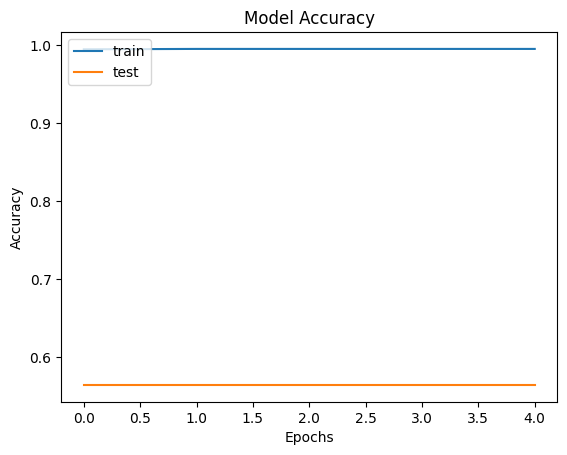

In [70]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Comparison of models

In [97]:
eval_df = pd.DataFrame(data = [rf_eval, gbm_eval, lgbm_eval, xgb_eval], 
                       columns = ['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'True Negatives', 'False Positives', 'Flase Negatives', 'True Positives'], 
                       index = ['Random Forest', 'Gradient Boosting', 'Light GBM', 'XG Boosting'])

In [98]:
eval_df

,Accuracy Score,Precision Score,Recall Score,F1 Score,True Negatives,False Positives,Flase Negatives,True Positives
Random Forest,0.999131,0.600787,0.976328,0.743846,1206321,1014,37,1526
Gradient Boosting,0.994916,0.197811,0.959693,0.328012,1201252,6083,63,1500
Light GBM,0.996912,0.294274,0.992962,0.454000,1203613,3722,11,1552
XG Boosting,0.998815,0.522032,0.992962,0.684303,1205914,1421,11,1552


In [73]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("LSTM Neural Network Accuracy", (scores[1]*100))

LSTM Neural Network Accuracy 99.8707115650177


# Saving the models

In [99]:
pickle.dump(rf, open('model/rf_model.pkl', 'wb'))